# Unbounded finite differences

Recall the 2nd-order centered difference

$$
u'(0) \approx \frac{-u(x-h) + u(x+h)}{2h},
$$

which results from interpolating by a parabola at $x=-h,0,h$. If we go outward two more grid points, the interpolant becomes quartic and we get the 4th-order formula

$$
u'(0) \approx \frac{u(x-2h) - 8u(x-h) + 8u(x+h) - u(x+2h)}{12h}.
$$

Continuing the process, the coefficients to the right of zero are 

$$
\begin{array}{ccccc}
1/2 &       &   &   &   \\ 
2/3 & -1/12 &   &   &    \\ 
3/4 & -3/20 & 1/60 & & \\ 
4/5 & -1/5 & 4/105 & -1/200 &  \\ 
5/6 & -5/21 & 5/84 & -5/504 & 1/1260 , 
\end{array}
$$

and so on.

### p1: convergence of fourth-order finite differences

In [1]:
using LinearAlgebra, SparseArrays

N = @. 2^(3:12)
err = zeros(size(N))
for (i,N) in enumerate(N)
    h = 2π / N
    x = @. -π + (1:N) * h
    u = @. exp(sin(x)^2)
    uʹ = @. 2 * sin(x) * cos(x) * u

    # Construct sparse fourth-order differentiation matrix:
    col1 = [ 0; -2/3h; 1/12h; zeros(N-5); -1/12h; 2/3h ]
    D = sparse( [col1[mod(i-j,N) + 1] for i in 1:N, j in 1:N] )

    # Plot max(abs(D*u-uʹ)):
    err[i] = norm(D * u - uʹ, Inf)
end

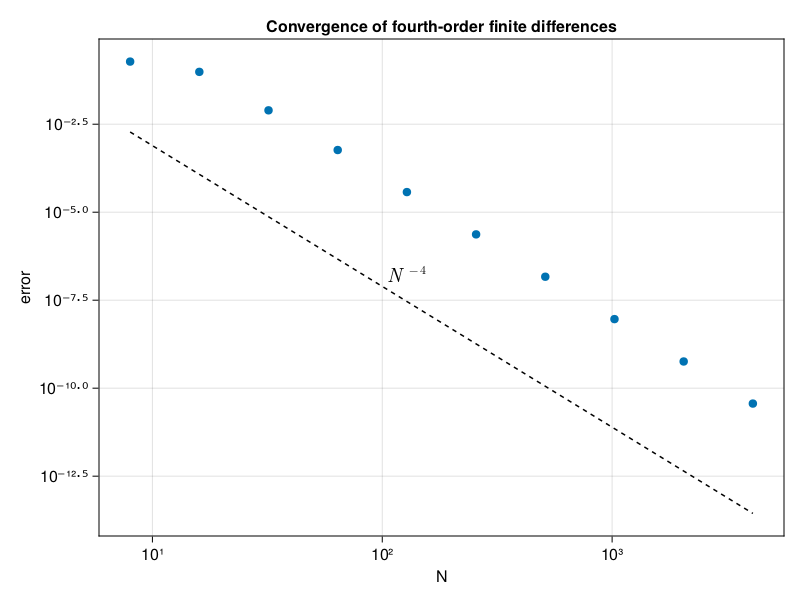

In [2]:
using CairoMakie

fig = Figure()
Axis(
    fig[1, 1],
    xscale=log10, yscale=log10,
    xlabel="N", ylabel="error",
    title="Convergence of fourth-order finite differences",
)

scatter!(N, err)
order4 = (N/N[1]) .^ (-4) * err[1] / 100
lines!(N, order4, color=:black, linestyle=:dash)
text!(105, 8e-8, text=L"N^{-4}")
fig

## Beyond all orders

It's not (yet) clear that each column in the numbers table above is tending toward a simple limit:

$$
\begin{array}{cccccc}
1 & -1/2 & 1/3  & -1/4  & 1/5  & \cdots 
\end{array}
$$

These values indicate that if we have data for $u$ on an unbounded grid $h\mathbb{Z}$, then we could in principle get an approximation

$$
h u'(0) \approx \bigl[ u(h)-u(-h) \bigr] - \tfrac{1}{2} \bigl[ u(2h)-u(-2h) \bigr] + \tfrac{1}{3} \bigl[ u(3h)-u(-3h) \bigr] + \cdots. 
$$

We might anticipate that this approximation is accurate *beyond all orders*, i.e., that the error decays more rapidly than any power of $h$ as $h\to 0$, at least sometimes. To compute derivatives at all of the grid points, we can (loosely) think of applying an infinite differentiation matrix whose rows are all shifted versions of 

$$
\frac{1}{h} \begin{bmatrix}
\cdots & 1/4 & -1/3 & 1/2 & -1 & 0 & 1 & -1/2 & 1/3  & -1/4  & \cdots 
\end{bmatrix}. 
$$

Each row represents the weights of all the values in affecting the derivative at one grid point. The columns are shifted versions of the *negative* of this infinite vector, and they represent the weight that a single value has at every point on the grid. 


There is, of course, the minor matter of the infinite sum. But we can circumvent that problem readily in at least one special case: a periodic function. Let $u_i=u(x_i)$ and suppose that the data is $N$-periodic, i.e., $u_i = u_{i \text{ mod } N}$ for all $i$. For example, if $N=4$, 

$$
h u'(0) & \approx \cdots \tfrac{1}{4}u_0 - \tfrac{1}{3}  u_1 + \tfrac{1}{2} u_2 - u_3 \\ 
& + u_1 - \tfrac{1}{2} u_2 + + \tfrac{1}{3} u_3 - \tfrac{1}{4} u_0 + \cdots . 
$$

Provided we do not worry about rearranging the order of the terms (which we should definitely worry about), we can collect all the multiples of each unique $u_i$ and evaluate infinite series to get coefficients in a finite differentiation matrix.

## Trig interpolation 

There is an easier way to proceed that happens to be equivalent. Suppose the function $u$ is $2\pi$-periodic, and $h=2\pi/N$, so that the data are $N$-periodic. Rather than starting with polynomials and taking an infinitely wide limit, it makes more sense to start over with a periodic interpolant and differentiate that to get the weights. Doing so produces an $N\times N$ matrix whose rows are the shifts of 

$$
\frac{1}{2} \begin{bmatrix}
\cdots & -\cot\left(\tfrac{3h}{2}\right) & \cot\left(\tfrac{2h}{2}\right) & -\cot\left(\tfrac{1h}{2}\right) & 0 & \cot\left(\tfrac{1h}{2}\right) & -\cot\left(\tfrac{2h}{2}\right) & \cdots 
\end{bmatrix}. 
$$

Observe that 

$$
\cot\left(\tfrac{(j+N)h}{2}\right) = \cot\left(\tfrac{jh}{2} + \pi \right) = \cot\left(\tfrac{jh}{2}\right), 
$$

so there are only $N$ unique entries in the row above. More precisely, if the matrix is $\bfD$, then

$$
D_{ij} = (-1)^{k} \cot\left(k \tfrac{h}{2}\right), \qquad k = i-j \mod N. 
$$

When the $(i,j)$ entry depends only on $(i-j) \mod N$, we say the matrix is **circulant**. We can use this property easily in a comprehension to construct the matrix.

### p2: convergence of periodic spectral method (compare p1)

In [3]:
N = 2:2:100
@assert(all(iseven.(N)),"N must be even")
err = zeros(size(N))

for (i,N) in enumerate(N)
    h = 2π / N
    x = [-π + i * h for i = 1:N]
    u = @. exp(sin(x))
    uʹ = @. cos(x) * u

    # Construct spectral differentiation matrix:
    entry(k) = k==0 ? 0.0 : (-1)^k * 0.5cot( k * h / 2 )
    D = [ entry(mod(i-j,N)) for i in 1:N, j in 1:N ]

    # Plot max(abs(D*u - uʹ)):
    err[i] = norm(D*u - uʹ, Inf)
end

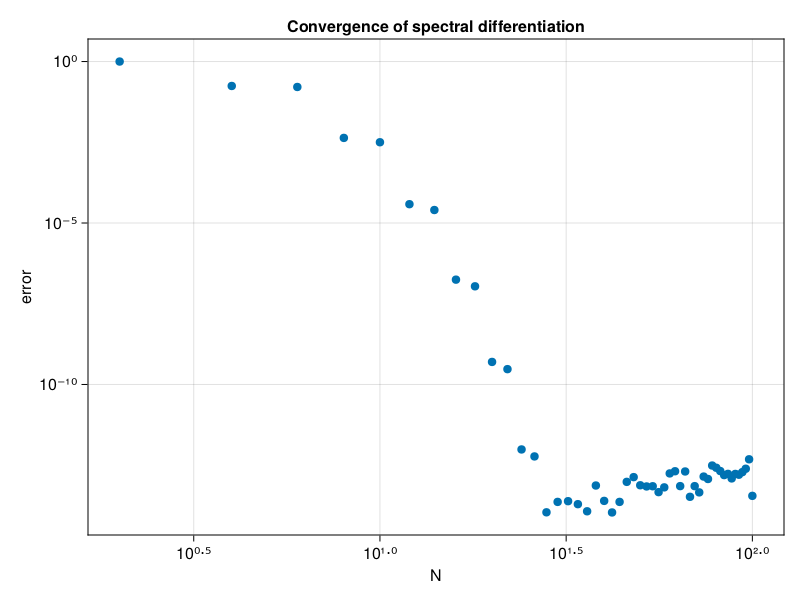

In [4]:
scatter(N, err, axis = (
    xlabel="N", xscale=log10, 
    ylabel="error", yscale=log10,
    title="Convergence of spectral differentiation"
))

This use of periodic interpolants is the foundation of **Fourier spectral methods.**